### Import libraries here

In [1]:
libPath = '/home/mayank/Documents/upgraded-octo-lamp/'
import sys
sys.path.append(libPath)
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from v2i.src.core.common import loadPKL

## Data files

In [42]:
onlyLV10mPath = "/home/mayank/ray_results/homogeneous-with-tf-LV-40m/onlyLocalView10m_gamma_0.999_shared_vf/data_tf_enabled.pkl"
onlyLV40mPath = "/home/mayank/ray_results/homogeneous-with-tf-LV-40m/onlyLocalView40m_gamma_0.999_shared_vf/data_tf_enabled.pkl"
FC40mPath = '/home/mayank/ray_results/homogeneous-with-tf-LV-40m/fullComm40m_gamma_0.999_vf_shared_part_2/data_tf_enabled.pkl'

# no tf lights
FC40mPathNoTF = '/home/mayank/ray_results/homogeneous-with-tf-LV-40m/fullComm40m_gamma_0.999_vf_shared_part_2/data_tf_disabled.pkl'
onlyLV10mNoTFPath = '/home/mayank/ray_results/homogeneous-with-tf-LV-40m/onlyLocalView10m_gamma_0.999_shared_vf/data_tf_disabled.pkl'
onlyLV40mNoTFPath = '/home/mayank/ray_results/homogeneous-with-tf-LV-40m/onlyLocalView40m_gamma_0.999_shared_vf/data_tf_disabled.pkl'

## Load all data

In [43]:
onlyLV10mData = loadPKL(onlyLV10mPath)
onlyLV40mData = loadPKL(onlyLV40mPath)
FC40mData = loadPKL(FC40mPath)

# no tf lights
FC40mDataNoTF = loadPKL(FC40mPathNoTF)
onlyLV10mDataNoTF = loadPKL(onlyLV10mNoTFPath)
onlyLV40mDataNoTF = loadPKL(onlyLV40mNoTFPath)

# Get density

In [30]:
episodesDensity = list(onlyLV10mData['data'].keys())[0]
print(episodesDensity)

0.2_0.2


# Assert episode density of all cases

In [31]:
assert list(onlyLV10mData['data'].keys())[0] == episodesDensity
assert list(onlyLV40mData['data'].keys())[0] == episodesDensity
assert list(FC40mData['data'].keys())[0] == episodesDensity

# Agent average speed comparison

In [32]:
def avgSpeed(dataDict):
    data = {}
    data['complete'] = []
    data['not-complete'] = []
    
    for episode in dataDict['data'][episodesDensity].keys():
        agentCarID = dataDict['data'][episodesDensity][episode]['agentCarID']
        epLen = len(dataDict['data'][episodesDensity][episode]['speed'][agentCarID])
        
        if epLen == (dataDict['max-episode-length'] + 1):
            agentCarID = dataDict['data'][episodesDensity][episode]['agentCarID']
            speedData = dataDict['data'][episodesDensity][episode]['speed'][agentCarID]
            data['complete'].append(speedData)
        else:
            speedData = dataDict['data'][episodesDensity][episode]['speed'][agentCarID]
            data['not-complete'].append(speedData)
    data['complete'] = np.array(data['complete'])
    totalEpisodes = len(data['complete']) + len(data['not-complete'])
    
    print("Complete episodes : %.2f"%(len(data['complete'])/totalEpisodes))
    print("%d/%d"%(len(data['complete']), totalEpisodes))
    return data

In [7]:
onlyLV10mspeedData = avgSpeed(onlyLV10mData)
onlyLV10mspeed = onlyLV10mspeedData['complete'].sum(axis=1) / onlyLV10mspeedData['complete'].shape[1]
onlyLV10mspeed *= 3.6

Complete episodes : 0.84
42/50


In [8]:
onlyLV40mspeedData = avgSpeed(onlyLV40mData)
onlyLV40mspeed = onlyLV40mspeedData['complete'].sum(axis=1) / onlyLV40mspeedData['complete'].shape[1]
onlyLV40mspeed *= 3.6

Complete episodes : 0.66
33/50


In [9]:
FC40mspeedData = avgSpeed(FC40mData)
FC40mspeed = FC40mspeedData['complete'].sum(axis=1) / FC40mspeedData['complete'].shape[1]
FC40mspeed *= 3.6

Complete episodes : 0.69
55/80


<IPython.core.display.Javascript object>


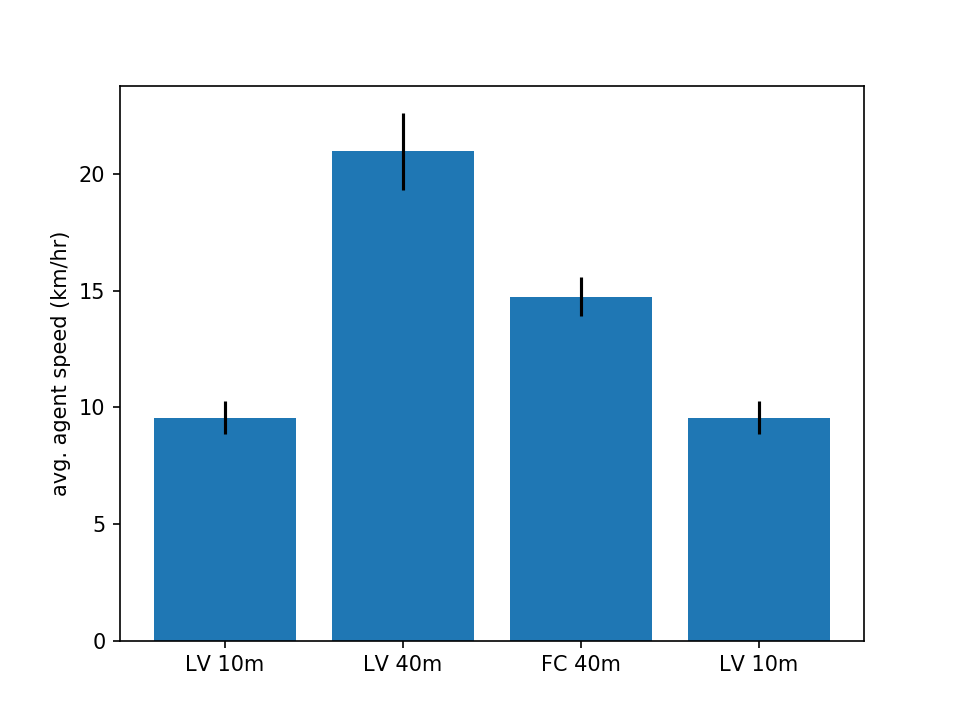

In [41]:
xticks = ['LV 10m', 'LV 40m', 'FC 40m', 'LV 10m']
plt.xticks([0, 1, 2, 3], xticks)
plt.bar([0, 1, 2, 3], [onlyLV10mspeed.mean(), onlyLV40mspeed.mean(), FC40mspeed.mean(), onlyLV10mspeed.mean()], yerr=[onlyLV10mspeed.std(), onlyLV40mspeed.std(), FC40mspeed.std(), onlyLV10mspeed.std()])
plt.ylabel('avg. agent speed (km/hr)')
plt.show()
#plt.grid()

### No TF case

In [44]:
FC40mspeedDataNoTF = avgSpeed(FC40mDataNoTF)
LV10mspeedDataNoTF = avgSpeed(onlyLV10mDataNoTF)
LV40mspeedDataNoTF = avgSpeed(onlyLV40mDataNoTF)

Complete episodes : 0.91
73/80
Complete episodes : 0.99
79/80
Complete episodes : 0.99
79/80


In [46]:
print(FC40mspeedDataNoTF['complete'].shape)
print(LV10mspeedDataNoTF['complete'].shape)
print(LV40mspeedDataNoTF['complete'].shape)

(73, 2201)
(79, 2201)
(79, 2201)


## Percentage of planning actions

In [13]:
def getPlanActStats(dataDict):
    data = {}
    data['complete'] = []
    data['not-complete'] = []
    
    for episode in dataDict['data'][episodesDensity].keys():
        actData = dataDict['data'][episodesDensity][episode]['actions']
        epLen = len(actData)
        if epLen == dataDict['max-episode-length']:
            data['complete'].append(actData)
        else:
            data['not-complete'].append(actData)
    totalEpisodes = len(data['complete']) + len(data['not-complete'])
    print("Complete episodes : %.2f"%(len(data['complete'])/totalEpisodes))
    print("%d/%d"%(len(data['complete']), totalEpisodes))
    return data

In [14]:
planEncode = {}
planEncode['acc'] = 0
planEncode['dec'] = 1
planEncode['do-nothing'] = 2
planEncode['lane-change'] = 3

In [15]:
regs = ['reg_0', 'reg_1', 'null']

In [16]:
def parsePlanActs(episodes, keyMap):
    dataCount = {}
    for key in keyMap:
        dataCount[key] = 0
    
    stepsCount = 0
    for episode in episodes:
        for step in episode:
            dataCount[step[0]] += 1
            stepsCount += 1
    
    # Normalize the dict
    for key in keyMap:
        dataCount[key] /= stepsCount

    # Convert into percentages
    for key in keyMap:
        dataCount[key] *= 100.0
    return dataCount

In [17]:
def parseRegs(episodes, keyMap):
    dataCount = {}
    for key in keyMap:
        dataCount[key] = 0
    
    stepsCount = 0
    for episode in episodes:
        for step in episode:
            dataCount[step[1]] += 1
            stepsCount += 1
    
    # Normalize the dict
    for key in keyMap:
        dataCount[key] /= stepsCount
    
    # Convert into percentages
    for key in keyMap:
        dataCount[key] *= 100.0
    return dataCount

In [18]:
onlyLV10mActsStat = getPlanActStats(onlyLV10mData)
onlyLV10mplanActs = parsePlanActs(onlyLV10mActsStat['complete'],planEncode)
print(onlyLV10mplanActs)

Complete episodes : 0.84
42/50
{'acc': 54.32251082251083, 'dec': 26.886363636363637, 'do-nothing': 18.76731601731602, 'lane-change': 0.023809523809523808}


In [19]:
onlyLV40mActsStat = getPlanActStats(onlyLV40mData)
onlyLV40mplanActs = parsePlanActs(onlyLV40mActsStat['complete'], planEncode)
print(onlyLV40mplanActs)

Complete episodes : 0.66
33/50
{'acc': 31.94490358126722, 'dec': 17.431129476584022, 'do-nothing': 43.24517906336089, 'lane-change': 7.378787878787879}


In [20]:
FC40mActsStat = getPlanActStats(FC40mData)
FC40mplanActs = parsePlanActs(FC40mActsStat['complete'], planEncode)
FC40mcommActs = parseRegs(FC40mActsStat['complete'], regs)

Complete episodes : 0.69
55/80


In [21]:
FC40mcommActs

{'reg_0': 31.262809917355373,
 'reg_1': 42.33884297520662,
 'null': 26.398347107438013}

<IPython.core.display.Javascript object>


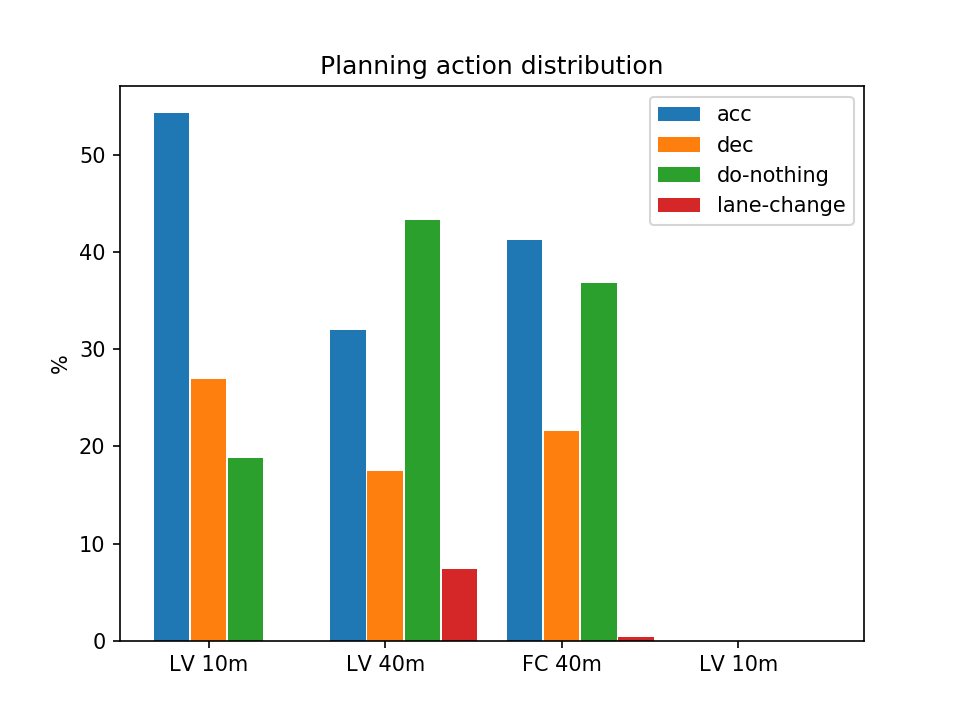

In [23]:
accBar = [onlyLV10mplanActs['acc'], onlyLV40mplanActs['acc'], FC40mplanActs['acc'], 0.0]
decBar = [onlyLV10mplanActs['dec'], onlyLV40mplanActs['dec'], FC40mplanActs['dec'], 0.0]
laneChangeBar = [onlyLV10mplanActs['lane-change'], onlyLV40mplanActs['lane-change'], FC40mplanActs['lane-change'], 0.0]
nothingBar = [onlyLV10mplanActs['do-nothing'], onlyLV40mplanActs['do-nothing'], FC40mplanActs['do-nothing'], 0.0]
plt.bar(np.array([0, 1, 2, 3]) - 0.21, accBar, width=0.2, label='acc')
plt.bar(np.array([0, 1, 2, 3]), decBar, width=0.2, label='dec')
plt.bar(np.array([0, 1, 2, 3]) + 0.21, nothingBar, width=0.2, label='do-nothing')
plt.bar(np.array([0, 1, 2, 3]) + 0.42, laneChangeBar, width=0.2, label='lane-change')
plt.xticks([0, 1, 2, 3], xticks)
plt.legend()
plt.ylabel('%')
plt.title('Planning action distribution')
plt.show()

<IPython.core.display.Javascript object>


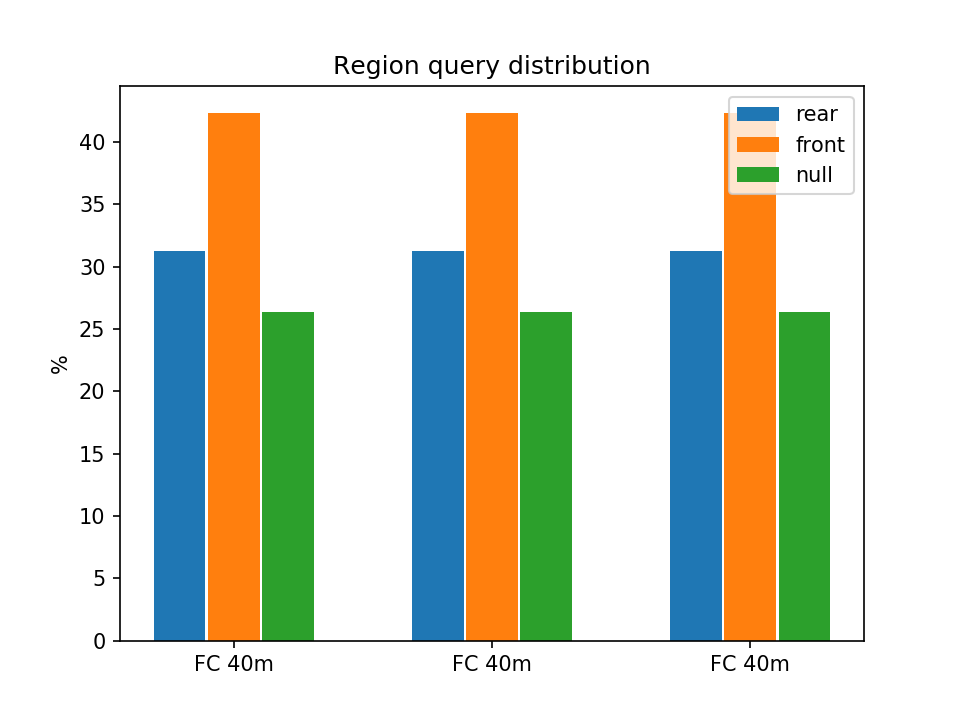

In [24]:
rearBar = [FC40mcommActs['reg_0'], FC40mcommActs['reg_0'], FC40mcommActs['reg_0']]
frontBar = [FC40mcommActs['reg_1'], FC40mcommActs['reg_1'], FC40mcommActs['reg_1']]
nullBar = [FC40mcommActs['null'], FC40mcommActs['null'], FC40mcommActs['null']]

xticks = ['FC 40m', 'FC 40m', 'FC 40m']
plt.xticks([0, 1, 2], xticks)
plt.bar(np.arange(0, len([0, 1, 2])) - 0.21, rearBar, width=0.2, label='rear')
plt.bar(np.arange(0, len([0, 1,2 ])), frontBar, width=0.2, label='front')
plt.bar(np.arange(0, len([0, 1, 2])) + 0.21, nullBar, width=0.2, label='null')
plt.legend()
plt.ylabel('%')
plt.title('Region query distribution')
plt.show()

## Agent speed as function of time

### with TF

<IPython.core.display.Javascript object>


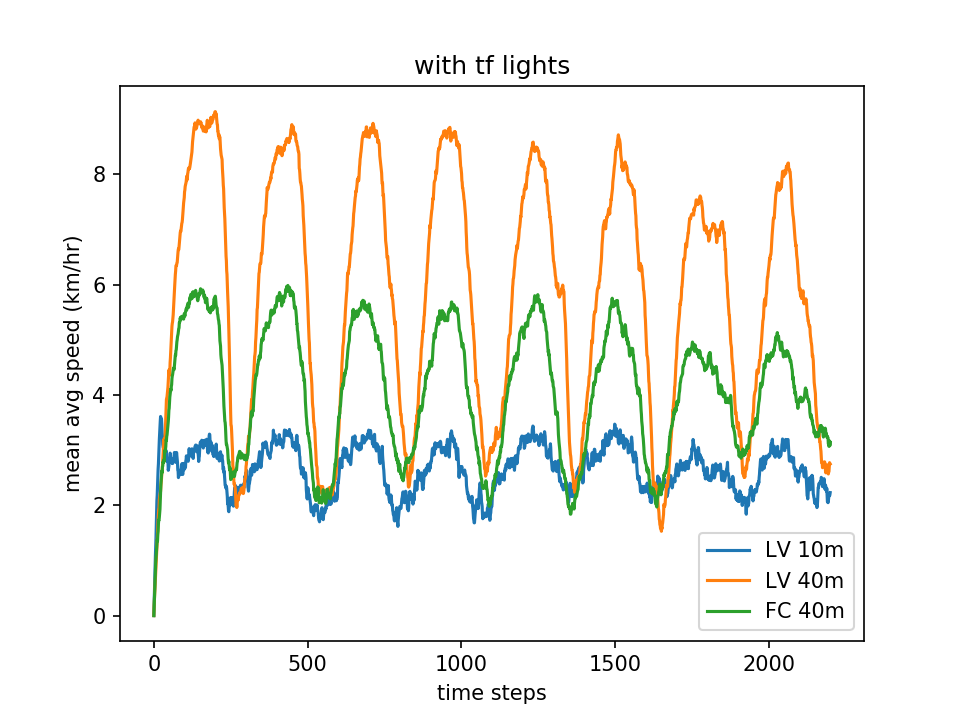

In [25]:
plt.plot(onlyLV10mspeedData['complete'].mean(axis=0), label='LV 10m')
plt.plot(onlyLV40mspeedData['complete'].mean(axis=0), label='LV 40m')
plt.plot(FC40mspeedData['complete'].mean(axis=0), label='FC 40m')
plt.xlabel('time steps')
plt.legend()
plt.title("with tf lights")
plt.ylabel('mean avg speed (km/hr)')
plt.show()

### Without TF

<IPython.core.display.Javascript object>


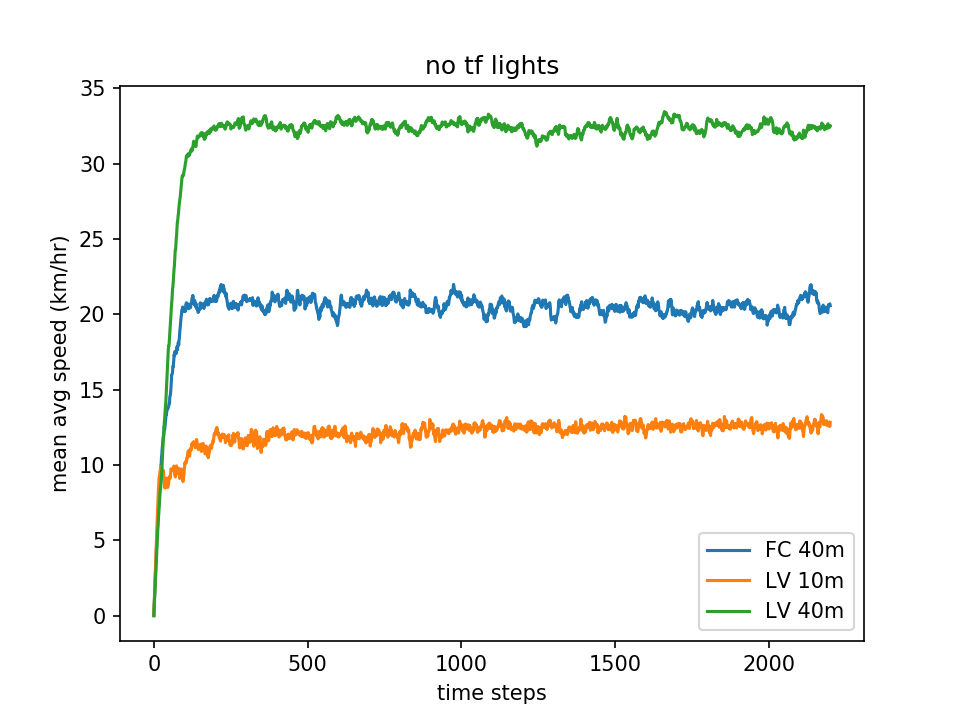

In [47]:
plt.plot(FC40mspeedDataNoTF['complete'].mean(axis=0) * 3.6, label='FC 40m')
plt.plot(LV10mspeedDataNoTF['complete'].mean(axis=0) * 3.6, label='LV 10m')
plt.plot(LV40mspeedDataNoTF['complete'].mean(axis=0) * 3.6, label='LV 40m')
plt.xlabel('time steps')
plt.legend()
plt.title("no tf lights")
plt.ylabel('mean avg speed (km/hr)')
plt.show()